/media/giancos/Football/dataset_crop224/england_epl/2014-2015/2015-05-17 - 18-00 Manchester United 1 - 1 Arsenal
9


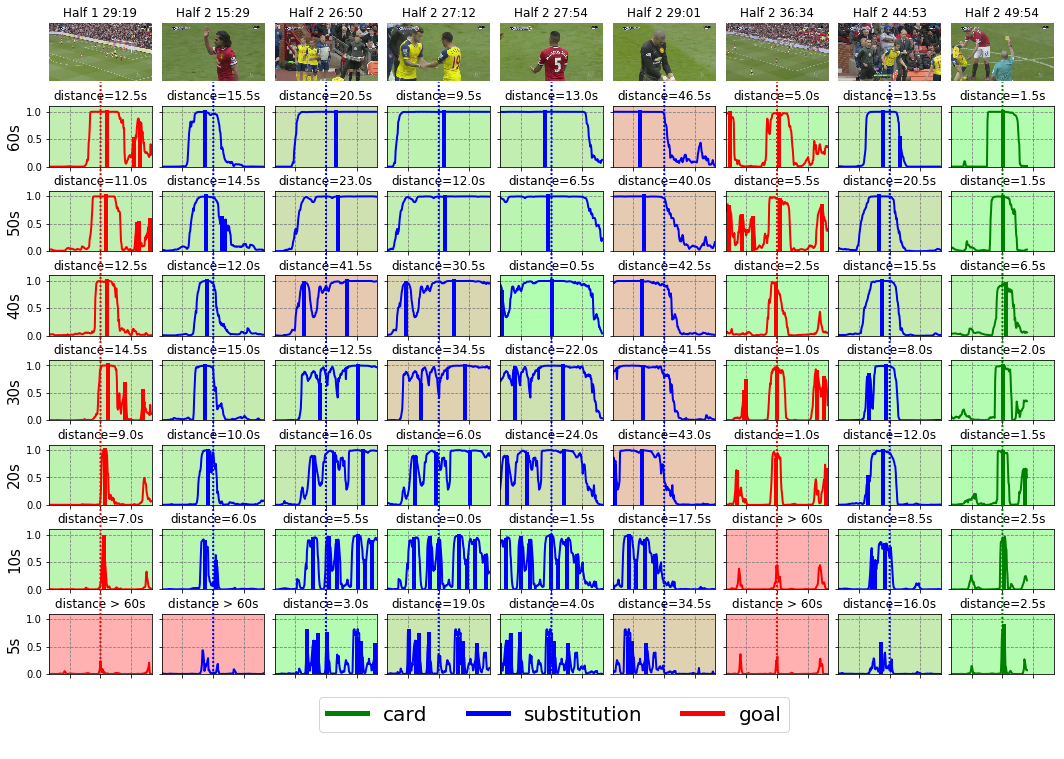

saving at: /home/giancos/Dropbox/Applicazioni/ShareLaTeX/CVPR18_Football/img/Supplementary/QualitativeResults_Wind.png


In [160]:
from matplotlib import pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib.image as mpimg
import matplotlib.lines as mlines

import numpy as np
import matplotlib

import numpy as np
import os
import json
from tqdm import tqdm 
import skvideo.io
from matplotlib import gridspec
import imageio

path_data_dirname = "/media/giancos/Football/dataset_crop224/"
path_data_dirname_frame = "/media/giancos/Football/dataset_224/"

labels = ["background", "card", "substitution", "goal"]

labels_color=["k", "#e6ab02", "#7570b3", "#e7298a"]
labels_color=["k", "g", "b", "r"]

color_good = [204.0,235.0,197.0] #"g"
color_bad = [251.0,180.0,174.0] #"r"
color_good = [0.0,255.0,0.0] #"g"
color_bad = [255.0,0.0,0.0] #"r"




# GET CANDIDATE SPOT FROM CENTER
def get_spot_from_Center(array, thresh=0.5):
    """Return the border of a prediction at a given watershed threshold"""
    diff1 = np.insert(array,0,0)
    diff2 = np.append(array,0)
    t_init = np.argwhere( (diff1<thresh) & (diff2>=thresh))[:,0]
    t_end  = np.argwhere( (diff1>thresh) & (diff2<=thresh))[:,0]
    score = np.zeros(len(t_end))
    t_spot = np.zeros(len(t_end))
    for i in range(len(t_end)):
#         score[i] = np.mean(array[t_init[i]:t_end[i]])
        t_spot[i] = (t_init[i] + t_end[i]) / 2
        score[i] = array[int(t_spot[i])]
    segment_predictions = np.transpose([t_init, t_end])
    return  np.transpose([t_spot, score])




def showResults(gamePath,savePath="", models=["Predictions"], Ylabels = [""], Legend = False, LegendLoc="lower center"):

    
    
    print(os.path.join(path_data_dirname, gamePath))

    with open(os.path.join(path_data_dirname, gamePath, "Labels.json")) as file :
        JsonFile = json.loads(file.read())

        print(len(JsonFile['annotations']))


        gs = gridspec.GridSpec(len(models)+1, len(JsonFile['annotations']), height_ratios=None)
        gs.update(wspace=0.1,hspace=0.4) # set the spacing between axes. 
        fig = plt.figure(figsize=(2*len(JsonFile['annotations']), 1.5+1.5*len(models)))
        transFigure = fig.transFigure.inverted()

#         fig, axs = plt.subplots(1,len(JsonFile['annotations']),num=None, 
#                 figsize=(2*len(JsonFile['annotations']), 3), 
#                 dpi=100, 
#                 facecolor='w',
#                 edgecolor='k',
#                                sharey=True)


        half = 2
        for i, myEvent in enumerate(JsonFile['annotations']):
#             print(i)
            
            # Get Video
            if (half == 2 and int(myEvent['gameTime'][:1]) == 1):
                videogen = skvideo.io.vreader(os.path.join(path_data_dirname_frame, gamePath, "1.mkv"),  backend='ffmpeg')
                index_frame = 0
            elif (half == 1 and int(myEvent['gameTime'][:1]) == 2):
                videogen = skvideo.io.vreader(os.path.join(path_data_dirname_frame, gamePath, "2.mkv"),  backend='ffmpeg')
                index_frame = 0
                
            # get Event
            half = int(myEvent['gameTime'][:1])
            second = int(myEvent['gameTime'][-2:])
            minute = int(myEvent['gameTime'][-5:-3])
            t=minute*60+second 
            time_t = "Half %1d %02d:%02d" % (half, t//60, t%60)
#             print(time_t)
            
            if "soccer" in myEvent['label']: index_label = 3
            elif "substitution" in myEvent['label']: index_label = 2
            elif "card" in myEvent['label']: index_label = 1
            else: index_label = 0
            
            
            

            # Get Frame and save short clp

            frame_fileName = os.path.join(path_data_dirname_frame, gamePath,
                                          "Frame_%1d_%02d_%02d_" % (half, minute, second) +  myEvent['label'] + ".png")

            if (os.path.exists(frame_fileName)): 
#                 import scipy
                arr_img = plt.imread(frame_fileName)
#                 arr_img = scipy.misc.imresize(arr_img, (224,224))       

            else:

                print("NOT exist")
                # try:
                clip = []
                for frame in videogen:

                    index_frame = index_frame + 1  

                    if (index_frame >= (t-5)*25.0):
                        clip.append(frame)

                    if (index_frame == t*25.0):
                        arr_img = frame
                        skvideo.io.vwrite(frame_fileName, arr_img)

                    if (index_frame >= (t+5)*25.0):
                        break


                # get Clip
                clip = np.array(clip)
#                 print(clip.shape)
                video_fileName = os.path.join(path_data_dirname_frame, gamePath,
                                              "Clip_%1d_%02d_%02d_" % (half, minute, second) +  myEvent['label'] + ".mp4")
                skvideo.io.vwrite(video_fileName, clip)

                gif_fileName = os.path.join(path_data_dirname_frame, gamePath,
                                              "GIF_%1d_%02d_%02d_" % (half, minute, second) +  myEvent['label'] + ".gif")


                imageio.mimsave(gif_fileName, clip, loop=1, duration=1/25.0)




            
            # IMAGE
            ax_img = plt.subplot(gs[0,i])
            plt.axis('off')
            plt.imshow(arr_img)
            plt.title(time_t)
            


            from matplotlib.patches import Circle, Rectangle
            from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
            from matplotlib.cbook import get_sample_data

            
            
                
            
            
            
            
            
            for i_model, model in enumerate(models):
                
                
                
                # Get Prediction
                if (half == 1):
    #                 predictions = np.load(os.path.join(path_data_dirname, gamePath, "Predictions_augm_50_Half_1.npy"))
                    predictions = np.load(os.path.join(path_data_dirname, gamePath, model + "_Half_1.npy"))
                elif (half == 2):
    #                 predictions = np.load(os.path.join(path_data_dirname, gamePath, "Predictions_augm_50_Half_2.npy"))
                    predictions = np.load(os.path.join(path_data_dirname, gamePath, model + "_Half_2.npy"))

            


                # get prediction using center
                search_around=100
                t_init = max(0,t-search_around)
                t_end = min(len(predictions),t+search_around)
                centers = get_spot_from_Center(predictions[t_init:t_end,index_label])  
                dist = 60
                for center in centers:
                    dist = min(np.abs(center[0] + t_init - t), dist)

    #             if (dist >= 60): dist = 60





            

                #### PLOT
                ax_plot = plt.subplot(gs[1+i_model,i])


                # plot activation in time
                for i_label in [index_label]:
    #             for i_label in [1,2,3]:
                    i_init = np.max([t-100, 0]) 
                    i_end = np.min([t+100, len(predictions[:,i_label])]) 
                    ax_plot.plot(np.arange(i_init,i_end), 
                            predictions[i_init:i_end,i_label],
                            linewidth=2.0, color=labels_color[i_label], label=labels[i_label])

    #             print(centers)
                for center in centers:
    #                 print(center)
                    ax_plot.plot([t-search_around+center[0],t-search_around+center[0]], 
                            [0,center[1]],
                            linewidth=4.0, color=labels_color[index_label], label=labels[index_label])


                ax_plot.set_xlim(t-100, t+100)

                ax_plot.tick_params(axis='both', which='major')
                plt.sca(ax_plot)



                ax_plot.set_axisbelow(True)
                ax_plot.xaxis.grid(color='gray', linestyle='dashed')
                ax_plot.yaxis.grid(color='gray', linestyle='dashed')            
                plt.xticks([t-60, t, t+60], ["", "", ""], rotation=45)


                ax_plot.set_ylim(0, 1.1)
                if (i == 0):
                    plt.yticks([0,0.5,1])
                    plt.ylabel(Ylabels[i_model], fontsize=15)
                else:
                    plt.yticks([0,0.5,1],["",""])
                if (dist<60):
                    plt.title("distance=" + str((dist)) + "s")
                else:
                    plt.title("distance > 60s")

                # COLOR FRAME
#                 if(dist<60):
#                     ax_plot.patch.set_facecolor(color_good)
#                 else:
#                     ax_plot.patch.set_facecolor(color_bad)
                alf = dist/60
#                 color_grad = [dist/60,1-dist/60, 0]
                color_grad = np.array((alf*np.array(color_bad) + (1-alf)*np.array(color_good))/255)
                ax_plot.patch.set_facecolor(color_grad)
                ax_plot.patch.set_alpha(0.3)
#                     rec = Rectangle((autoAxis[0]-0.7,autoAxis[2]-0.2),(autoAxis[1]-autoAxis[0])+1,
#                                     (autoAxis[3]-autoAxis[2])+0.4,fill=False,lw=5,color=color_bad)
#                 autoAxis = ax_plot.axis()
#                 if(dist<60):
#                     rec = Rectangle((autoAxis[0]-0.7,autoAxis[2]-0.2),(autoAxis[1]-autoAxis[0])+1,
#                                     (autoAxis[3]-autoAxis[2])+0.4,fill=False,lw=5,color=color_good)
#                 else:
#                     rec = Rectangle((autoAxis[0]-0.7,autoAxis[2]-0.2),(autoAxis[1]-autoAxis[0])+1,
#                                     (autoAxis[3]-autoAxis[2])+0.4,fill=False,lw=5,color=color_bad)
#                 rec = ax_plot.add_patch(rec)
#                 rec.set_clip_on(False)
                
                
                
                

                ##### CONNECTION
                if (i_model+1 == len(models)):
                    coord1 = transFigure.transform(ax_plot.transAxes.transform([0.5,0.05]))
                    coord2 = transFigure.transform(ax_img.transData.transform([arr_img.shape[1]/2,224]))

                    line = matplotlib.lines.Line2D((coord1[0],coord2[0]),(coord1[1],coord2[1]), 
                                                   linestyle='--',  dashes=(1, 1), lw=2,
                                                   transform=fig.transFigure,color=labels_color[index_label])
                    fig.lines.append(line)
                    
                    
                   

#                     for i in xrange(5):
#                         line, = ax.plot(x, i * x, label='$y = %ix$'%i)

#                     fig.transFigure
#                     # Shrink current axis's height by 10% on the bottom

#                     if(i == 1):
#         fig.transFigure
#                         box = ax_plot.get_position()
#                         ax_plot.set_position([box.x0, box.y0 + box.height * 0.1,
#                                          box.width, box.height * 0.9])

                        # Put a legend below current axis
                        


        if(Legend):
            l1 = mlines.Line2D([],[], color=labels_color[1], label=labels[1])               
            l2 = mlines.Line2D([],[], color=labels_color[2], label=labels[2])               
            l3 = mlines.Line2D([],[], color=labels_color[3], label=labels[3])               
            legend = fig.legend(handles=[l1,l2,l3], labels=labels[1:4], loc=LegendLoc, ncol=5, fontsize=20) 
            for label in legend.get_lines():
                label.set_linewidth(5)  # the legend line width
#         fig.legend(handles=[l1,l2,l3], labels=labels[1:4], loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=5)
        plt.show()

#         path_figure = os.path.join(path_data_dirname, gamePath, "QualitativeResults.png")
        if (savePath != ""):
            print("saving at:" ,savePath)
            fig.savefig(savePath, bbox_inches='tight')


# showResults(gamePath = np.load(os.path.join(path_data_dirname, "listgame_train_300.npy"))[0])
# showResults(gamePath = np.load(os.path.join(path_data_dirname, "listgame_valid_100.npy"))[0])
# showResults(gamePath = np.load(os.path.join(path_data_dirname, "listgame_test_100.npy"))[0])
# print(np.load(os.path.join(path_data_dirname, "listgame_test_100.npy"))[0])
# showResults(gamePath = "europe_uefa-champions-league/2015-2016/2015-11-03 - 22-45 Real Madrid 1 - 0 Paris SG")
# showResults(gamePath = "europe_uefa-champions-league/2015-2016/2015-11-03 - 22-45 Sevilla 1 - 3 Manchester City")
# showResults(gamePath = "europe_uefa-champions-league/2015-2016/2015-11-03 - 22-45 Shakhtar Donetsk 4 - 0 Malmo FF")
# showResults(gamePath = "europe_uefa-champions-league/2015-2016/2015-11-04 - 22-45 Barcelona 3 - 0 BATE")
# showResults(gamePath = "europe_uefa-champions-league/2015-2016/2015-11-04 - 22-45 Bayern Munich 5 - 1 Arsenal")
# showResults(gamePath = "europe_uefa-champions-league/2015-2016/2015-11-04 - 22-45 Gent 1 - 0 Valencia")
# showResults(gamePath = "europe_uefa-champions-league/2015-2016/2015-11-04 - 22-45 Lyon 0 - 2 Zenit Petersburg")
# showResults(gamePath = "europe_uefa-champions-league/2015-2016/2015-11-04 - 22-45 Maccabi Tel Aviv 1 - 3 FC Porto")
# showResults(gamePath = "europe_uefa-champions-league/2015-2016/2015-11-24 - 20-00 BATE 1 - 1 Bayer Leverkusen")
# showResults(gamePath = "europe_uefa-champions-league/2015-2016/2015-11-24 - 20-00 Zenit Petersburg 2 - 0 Valencia")
# showResults(gamePath = "europe_uefa-champions-league/2015-2016/2015-11-24 - 22-45 Barcelona 6 - 1 AS Roma")
# showResults(gamePath = "europe_uefa-champions-league/2015-2016/2015-11-24 - 22-45 Bayern Munich 4 - 0 Olympiakos Piraeus")
# showResults(gamePath = "europe_uefa-champions-league/2015-2016/2015-11-24 - 22-45 FC Porto 0 - 2 Dyn. Kiev")
# showResults(gamePath = "europe_uefa-champions-league/2015-2016/2015-11-24 - 22-45 Maccabi Tel Aviv 0 - 4 Chelsea")
# showResults(gamePath = "europe_uefa-champions-league/2015-2016/2015-11-25 - 20-00 CSKA Moscow 0 - 2 Wolfsburg")
# showResults(gamePath = "europe_uefa-champions-league/2015-2016/2015-11-25 - 22-45 Atl. Madrid 2 - 0 Galatasaray")
# showResults(gamePath = "europe_uefa-champions-league/2015-2016/2015-11-25 - 22-45 B. Monchengladbach 4 - 2 Sevilla")
# showResults(gamePath = "europe_uefa-champions-league/2015-2016/2015-11-25 - 22-45 Juventus 1 - 0 Manchester City")
# showResults(gamePath = "europe_uefa-champions-league/2015-2016/2015-11-25 - 22-45 Malmo FF 0 - 5 Paris SG")
# showResults(gamePath = "europe_uefa-champions-league/2015-2016/2015-11-25 - 22-45 Shakhtar Donetsk 3 - 4 Real Madrid")
# showResults(gamePath = "europe_uefa-champions-league/2015-2016/2015-12-09 - 22-45 D. Zagreb 0 - 2 Bayern Munich")
# showResults(gamePath = "europe_uefa-champions-league/2015-2016/2016-04-05 - 21-45 Bayern Munich 1 - 0 Benfica")


showResults(gamePath = np.load(os.path.join(path_data_dirname, "listgame_test_100.npy"))[0],
            savePath = "/home/giancos/Dropbox/Applicazioni/ShareLaTeX/CVPR18_Football/img/Supplementary/QualitativeResults_Wind.png",
            models = ["Predictions_augm_"+str(k) for k in [60,50,40,30,20,10,5]],
            Ylabels = [str(k)+"s" for k in [60,50,40,30,20,10,5]], 
            Legend=True, LegendLoc=(0.3,0.035))  

# showResults(gamePath = np.load(os.path.join(path_data_dirname, "listgame_test_100.npy"))[0],
#             models = ["Predictions_augm_"+str(k) for k in [60,50,40]],
#             Ylabels = ["60s", "50s", "40s"], 
#             Legend=True) 



/media/giancos/Football/dataset_crop224/england_epl/2015-2016/2015-08-16 - 18-00 Manchester City 3 - 0 Chelsea
15
NOT exist


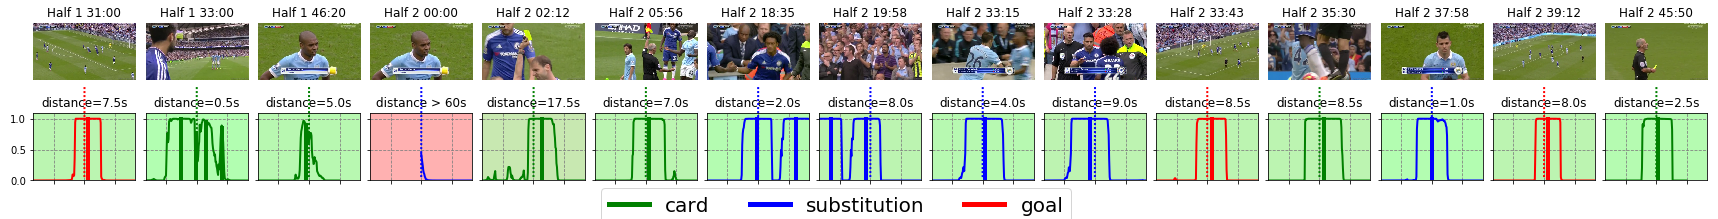

saving at: /home/giancos/Dropbox/Applicazioni/ShareLaTeX/CVPR18_Football/img/Supplementary/QualitativeResults_Test1.png


In [161]:
# gamePath = "england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/"
# gamePath = "england_epl/2014-2015/2015-05-17 - 18-00 Manchester United 1 - 1 Arsenal/"
# gamePath = "england_epl/2014-2015/2015-05-17 - 18-00 Manchester United 1 - 1 Arsenal/"
# for gamePath in np.load(os.path.join(path_data_dirname, "listgame_test_100.npy")):

# for gamePath in np.load(os.path.join(path_data_dirname, "listgame.npy")):


# for gamePath in [np.load(os.path.join(path_data_dirname, "listgame_train_300.npy"))[0],
#                  np.load(os.path.join(path_data_dirname, "listgame_valid_100.npy"))[0],
#                  np.load(os.path.join(path_data_dirname, "listgame_test_100.npy"))[0]]:
    
showResults(gamePath = np.load(os.path.join(path_data_dirname, "listgame_train_300.npy"))[0],
            savePath = "/home/giancos/Dropbox/Applicazioni/ShareLaTeX/CVPR18_Football/img/Supplementary/QualitativeResults_Train0.png")
showResults(gamePath = np.load(os.path.join(path_data_dirname, "listgame_train_300.npy"))[1],
            savePath = "/home/giancos/Dropbox/Applicazioni/ShareLaTeX/CVPR18_Football/img/Supplementary/QualitativeResults_Train1.png")


showResults(gamePath = np.load(os.path.join(path_data_dirname, "listgame_valid_100.npy"))[1],
            savePath = "/home/giancos/Dropbox/Applicazioni/ShareLaTeX/CVPR18_Football/img/Supplementary/QualitativeResults_Valid0.png")
showResults(gamePath = np.load(os.path.join(path_data_dirname, "listgame_valid_100.npy"))[2],
            savePath = "/home/giancos/Dropbox/Applicazioni/ShareLaTeX/CVPR18_Football/img/Supplementary/QualitativeResults_Valid1.png")


showResults(gamePath = np.load(os.path.join(path_data_dirname, "listgame_test_100.npy"))[0],
            savePath = "/home/giancos/Dropbox/Applicazioni/ShareLaTeX/CVPR18_Football/img/Supplementary/QualitativeResults_Test0.png")
showResults(gamePath = np.load(os.path.join(path_data_dirname, "listgame_test_100.npy"))[1],
            savePath = "/home/giancos/Dropbox/Applicazioni/ShareLaTeX/CVPR18_Football/img/Supplementary/QualitativeResults_Test1.png",
            Legend=True, LegendLoc=(0.35,-0.02))

/media/giancos/Football/dataset_crop224/europe_uefa-champions-league/2015-2016/2015-11-04 - 22-45 Gent 1 - 0 Valencia
12
NOT exist
NOT exist
NOT exist
NOT exist
NOT exist
NOT exist
NOT exist
NOT exist
NOT exist
NOT exist
NOT exist
NOT exist


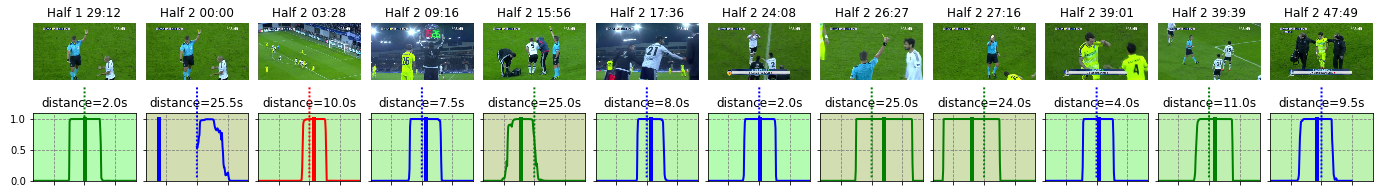

/media/giancos/Football/dataset_crop224/europe_uefa-champions-league/2015-2016/2015-11-04 - 22-45 Lyon 0 - 2 Zenit Petersburg
17
NOT exist
NOT exist
NOT exist
NOT exist
NOT exist
NOT exist
NOT exist
NOT exist
NOT exist
NOT exist
NOT exist
NOT exist
NOT exist
NOT exist
NOT exist
NOT exist
NOT exist


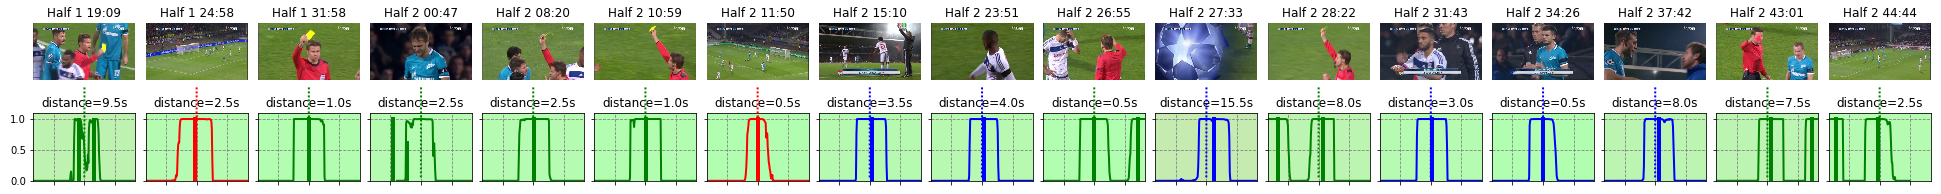

/media/giancos/Football/dataset_crop224/europe_uefa-champions-league/2015-2016/2015-11-04 - 22-45 Maccabi Tel Aviv 1 - 3 FC Porto
13
NOT exist
NOT exist
NOT exist
NOT exist
NOT exist
NOT exist
NOT exist
NOT exist
NOT exist
NOT exist
NOT exist
NOT exist
NOT exist


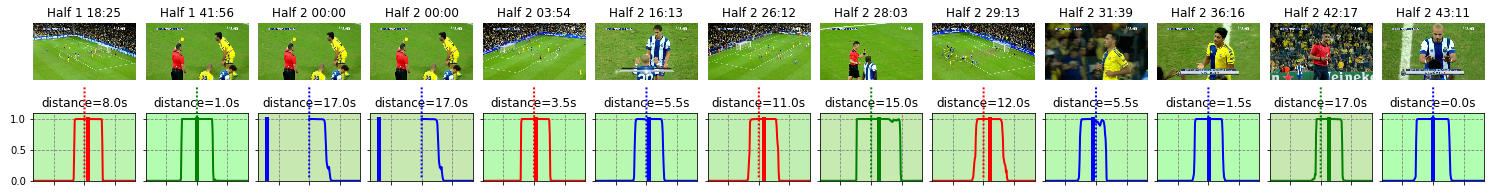

In [162]:
# showResults(gamePath = np.load(os.path.join(path_data_dirname, "listgame_test_100.npy"))[1])
showResults(gamePath = "europe_uefa-champions-league/2015-2016/2015-11-04 - 22-45 Gent 1 - 0 Valencia")
showResults(gamePath = "europe_uefa-champions-league/2015-2016/2015-11-04 - 22-45 Lyon 0 - 2 Zenit Petersburg")
showResults(gamePath = "europe_uefa-champions-league/2015-2016/2015-11-04 - 22-45 Maccabi Tel Aviv 1 - 3 FC Porto")

In [73]:
   
for Wind in [60,50,40,30,20,10,5]:
#     showResults(gamePath = np.load(os.path.join(path_data_dirname, "listgame_train_300.npy"))[1],
#                 savePath = "/home/giancos/Dropbox/Applicazioni/ShareLaTeX/CVPR18_Football/img/Supplementary/QualitativeResults_Wind"+str(Wind)+".png",
#                 model = "Predictions_augm_"+str(Wind))   
#     showResults(gamePath = np.load(os.path.join(path_data_dirname, "listgame_valid_100.npy"))[2],
#                 savePath = "/home/giancos/Dropbox/Applicazioni/ShareLaTeX/CVPR18_Football/img/Supplementary/QualitativeResults_Wind"+str(Wind)+".png",
#                 model = "Predictions_augm_"+str(Wind))   
        showResults(gamePath = np.load(os.path.join(path_data_dirname, "listgame_test_100.npy"))[2],
                savePath = "/home/giancos/Dropbox/Applicazioni/ShareLaTeX/CVPR18_Football/img/Supplementary/QualitativeResults_Wind"+str(Wind)+".png",
                model = "Predictions_augm_"+str(Wind))   
    
    
    


TypeError: showResults() got an unexpected keyword argument 'model'

In [ ]:
        showResults(gamePath = np.load(os.path.join(path_data_dirname, "listgame_test_100.npy"))[2],
                savePath = "/home/giancos/Dropbox/Applicazioni/ShareLaTeX/CVPR18_Football/img/Supplementary/QualitativeResults_Wind"+str(Wind)+".png",
                model = "Predictions_augm_"+str(Wind))   

In [ ]:
# print(os.path.join(path_data_dirname, 
#                             np.load(os.path.join(path_data_dirname, "listgame_test_100.npy"))[0],
#                             "QualitativeResults.png"))
for i in range(100):  
    print(i)
    showResults(gamePath = np.load(os.path.join(path_data_dirname, "listgame_test_100.npy"))[i],
                savePath = os.path.join(path_data_dirname, 
                            np.load(os.path.join(path_data_dirname, "listgame_test_100.npy"))[i],
                            "QualitativeResults.png") )
    
    
for i in range(100):  
    print(i+100)
    showResults(gamePath = np.load(os.path.join(path_data_dirname, "listgame_valid_100.npy"))[i],
                savePath = os.path.join(path_data_dirname, 
                            np.load(os.path.join(path_data_dirname, "listgame_valid_100.npy"))[i],
                            "QualitativeResults.png") )
    
    
for i in range(300):  
    print(i+400) 
    showResults(gamePath = np.load(os.path.join(path_data_dirname, "listgame_train_300.npy"))[i],
                savePath = os.path.join(path_data_dirname, 
                            np.load(os.path.join(path_data_dirname, "listgame_train_300.npy"))[i],
                            "QualitativeResults.png") )

/media/giancos/Football/dataset_crop224/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley
10


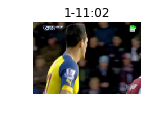

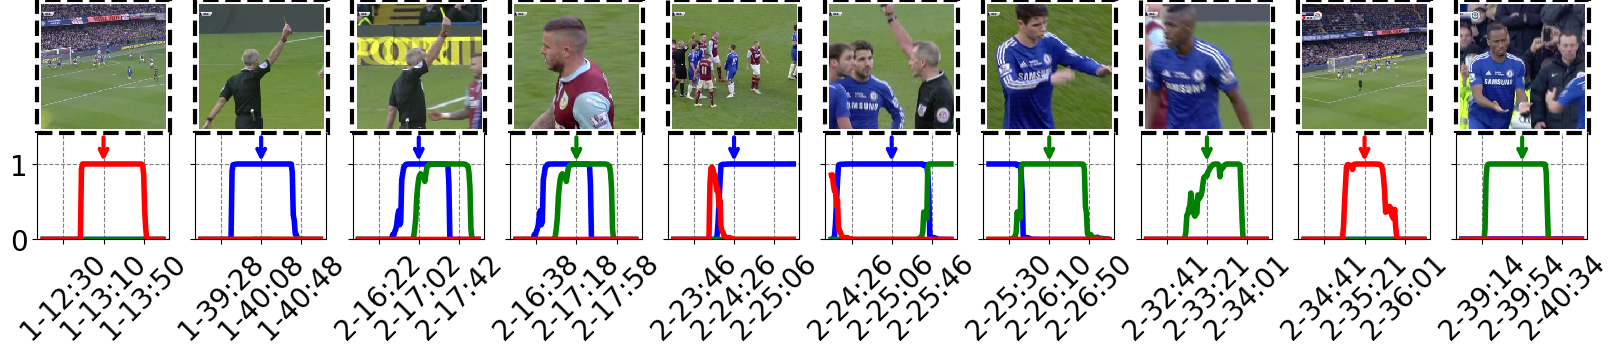

/media/giancos/Football/dataset_crop224/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/QualitativeResults.png
/media/giancos/Football/dataset_crop224/england_epl/2014-2015/2015-04-11 - 19-30 Burnley 0 - 1 Arsenal
6


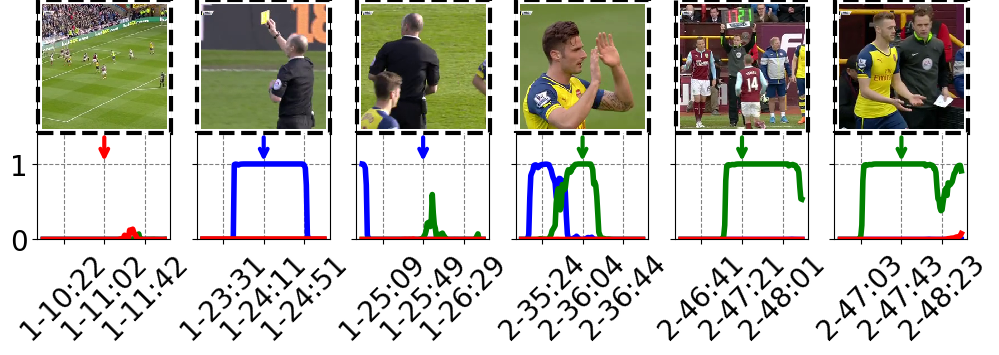

/media/giancos/Football/dataset_crop224/england_epl/2014-2015/2015-04-11 - 19-30 Burnley 0 - 1 Arsenal/QualitativeResults.png
/media/giancos/Football/dataset_crop224/england_epl/2014-2015/2015-05-17 - 18-00 Manchester United 1 - 1 Arsenal
9


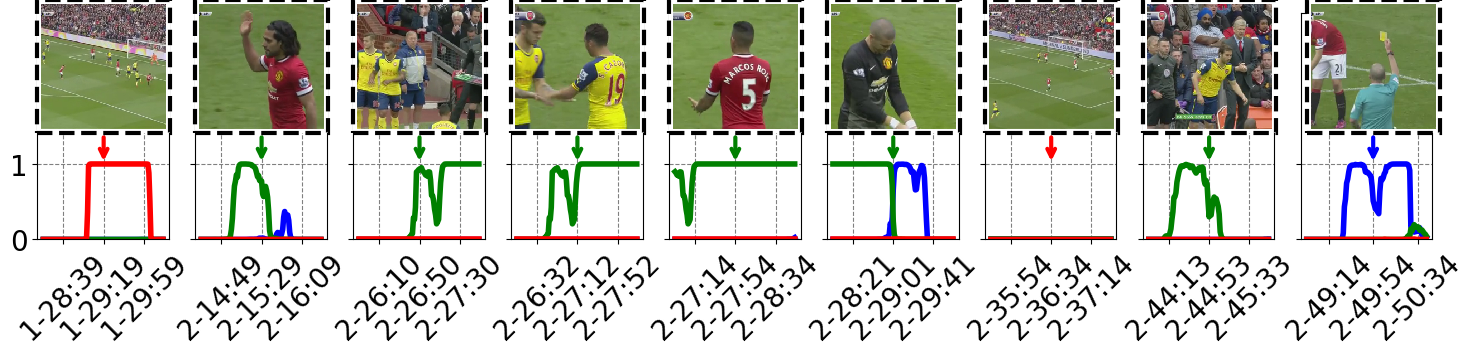

/media/giancos/Football/dataset_crop224/england_epl/2014-2015/2015-05-17 - 18-00 Manchester United 1 - 1 Arsenal/QualitativeResults.png


In [8]:
from matplotlib import pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib.image as mpimg

import numpy as np
import matplotlib

import numpy as np
import os
import json
from tqdm import tqdm 
import skvideo.io

path_data_dirname = "/media/giancos/Football/dataset_crop224/"

labels = ["background", "card", "substitution", "goal"]

gamePath = "england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/"
# gamePath = "england_epl/2014-2015/2015-05-17 - 18-00 Manchester United 1 - 1 Arsenal/"
# gamePath = "england_epl/2014-2015/2015-05-17 - 18-00 Manchester United 1 - 1 Arsenal/"
# for gamePath in np.load(os.path.join(path_data_dirname, "listgame_test_100.npy")):

# for gamePath in np.load(os.path.join(path_data_dirname, "listgame.npy")):


for gamePath in [np.load(os.path.join(path_data_dirname, "listgame_train_300.npy"))[0],
                 np.load(os.path.join(path_data_dirname, "listgame_valid_100.npy"))[0],
                 np.load(os.path.join(path_data_dirname, "listgame_test_100.npy"))[0]]:


    print(os.path.join(path_data_dirname, gamePath))

    with open(os.path.join(path_data_dirname, gamePath, "Labels.json")) as file :
        JsonFile = json.loads(file.read())

        print(len(JsonFile['annotations']))




        fig, axs = plt.subplots(1,len(JsonFile['annotations']),num=None, 
                figsize=(2*len(JsonFile['annotations']), 3), 
                dpi=100, 
                facecolor='w',
                edgecolor='k',
                               sharey=True)


        half = 2
        for i, myEvent in enumerate(JsonFile['annotations']):
            if (half == 2 and int(myEvent['gameTime'][:1]) == 1):
                videogen = skvideo.io.vreader(os.path.join(path_data_dirname, gamePath, "1.mkv"),  backend='ffmpeg')
                index_frame = 0
            elif (half == 1 and int(myEvent['gameTime'][:1]) == 2):
                videogen = skvideo.io.vreader(os.path.join(path_data_dirname, gamePath, "2.mkv"),  backend='ffmpeg')
                index_frame = 0


            half = int(myEvent['gameTime'][:1])
            second = int(myEvent['gameTime'][-2:])
            minute = int(myEvent['gameTime'][-5:-3])

            t=minute*60+second     

            if (half == 1):
                predictions = np.load(os.path.join(path_data_dirname, gamePath, "Predictions_augm_50_Half_1.npy"))
                predictions = np.load(os.path.join(path_data_dirname, gamePath, "Predictions_Half_1.npy"))
            elif (half == 2):
                predictions = np.load(os.path.join(path_data_dirname, gamePath, "Predictions_augm_50_Half_2.npy"))
                predictions = np.load(os.path.join(path_data_dirname, gamePath, "Predictions_Half_2.npy"))

                
            frame_fileName = os.path.join(path_data_dirname, gamePath,
                                          "Frame_%1d_%02d_%02d_" % (half, minute, second) +  myEvent['label'] + ".png")
#             print(frame_fileName)
            if (os.path.exists(frame_fileName)):
#                 print("exist")                
                arr_img = plt.imread(frame_fileName)
            
            else:
                print("NOT exist")
                continue
                    


                    



            ax = axs[i]
            ax.set_axisbelow(True)
            ax.xaxis.grid(color='gray', linestyle='dashed')
            ax.yaxis.grid(color='gray', linestyle='dashed')


#             ax.plot( [t,t], 
#                     [0,1],
#                     linewidth=4.0, color="k")

            labels= ["background", "card", "substitution", "goal"]
            c=["k", "b", "g", "r"]

            for i_label in [1,2,3]:
                i_init = np.max([t-60, 0]) 
                i_end = np.min([t+60, len(predictions[:,i_label])]) 
                ax.plot(np.arange(i_init,i_end), 
                        predictions[i_init:i_end,i_label],
                        linewidth=4.0, color=c[i_label], label=labels[i_label])



            ax.tick_params(axis='both', which='major', labelsize=20)
            plt.sca(ax)
            
            off = 40
            time_init = "%1d-%02d:%02d" % (half, (t-off)//60, (t-off)%60)
            time_end = "%1d-%02d:%02d" % (half, (t+off)//60, (t+off)%60)
            time_t = "%1d-%02d:%02d" % (half, t//60, t%60)
            
            locs, labels = plt.xticks([t-off, t, t+off], 
                                      [time_init, time_t, time_end], 
                                      rotation=45)


            
        

            from matplotlib.patches import Circle
            from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                              AnnotationBbox)
            from matplotlib.cbook import get_sample_data


            imagebox = OffsetImage(arr_img, zoom=0.4)
            imagebox.image.axes = ax



            
            if "soccer" in myEvent['label']: color = c[3]
            elif "substitution" in myEvent['label']: color = c[2]
            elif "card" in myEvent['label']: color = c[1]
            else: color = c[0]

                
#             if predictions(t,?) >= 0.5: linestyle="-"
#             elif predictions(t,?) < 0.5: linestyle='--'
            linestyle='--'
                
            ab = AnnotationBbox(imagebox, (t,1),
                             xybox=(-0., 70.),
                            xycoords='data',
                            boxcoords="offset points",
                            pad=0.3,
                            bboxprops=dict( linestyle=linestyle,linewidth=3),
                            arrowprops=dict(arrowstyle="->",color=color,linewidth=3))

            ax.add_artist(ab)

            
            ax.set_ylim(0, 3)
            plt.sca(ax)
            plt.yticks([0,1])
            
            
            
            
#         box = ax.get_position()
#         ax.set_position([box.x0, box.y0 + box.height * 0.1,
#         box.width, box.height * 0.9])
#         ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#                   fancybox=True, shadow=True, ncol=5)

#         from matplotlib.font_manager import FontProperties

#         fontP = FontProperties()
#         fontP.set_size('small')
#         legend([plot1], "title", prop=fontP)

        plt.show()

        path_figure = os.path.join(path_data_dirname, gamePath, "QualitativeResults.png")
        print(path_figure)
        fig.savefig(path_figure, bbox_inches='tight')






In [92]:
# Red in Goal, Blue is card, Green is substitution